In [4]:
# !pip -q install datasets pyarrow pandas numpy tqdm

In [5]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

SUBSET_NAME = "flat-multievent-50m"
SPLIT = "train"

# keep small and safe first; you can raise later
MAX_ROWS = 1_000_000   # start with 1M, later you can try 2M
SEED = 42

In [6]:
#Stream-load the dataset
ds = load_dataset(
    "yandex/yambda",
    name=SUBSET_NAME,
    split=SPLIT,
    streaming=True
)

ds

IterableDataset({
    features: ['uid', 'timestamp', 'item_id', 'is_organic', 'played_ratio_pct', 'track_length_seconds', 'event_type'],
    n_shards: 1
})

In [7]:
#Pull a sample into a DataFrame
rows = []
for i, r in enumerate(tqdm(ds, total=MAX_ROWS)):
    rows.append(r)
    if i + 1 >= MAX_ROWS:
        break

df = pd.DataFrame(rows)
df.head(), df.shape

100%|████████████████████████████████████▉| 999999/1000000 [01:19<00:00, 12641.78it/s]


(   uid  timestamp  item_id  is_organic  played_ratio_pct  \
 0  100      39420  8326270           0             100.0   
 1  100      39420  1441281           0             100.0   
 2  100      39625   286361           0             100.0   
 3  100      40110   732449           0             100.0   
 4  100      40360  3397170           0              46.0   
 
    track_length_seconds event_type  
 0                 170.0     listen  
 1                 105.0     listen  
 2                 185.0     listen  
 3                 240.0     listen  
 4                 130.0     listen  ,
 (1000000, 7))

In [8]:
#Keep only columns you need
needed = ["uid", "item_id", "timestamp", "is_organic", "event_type", "played_ratio_pct", "track_length_seconds"]
df = df[needed].copy()

# Make sure numeric types are clean
df["uid"] = df["uid"].astype("int64")
df["item_id"] = df["item_id"].astype("int64")
df["timestamp"] = df["timestamp"].astype("int64")
df["is_organic"] = df["is_organic"].astype("int64")

df.head()

,uid,item_id,timestamp,is_organic,event_type,played_ratio_pct,track_length_seconds
0,100,8326270,39420,0,listen,100.0,170.0
1,100,1441281,39420,0,listen,100.0,105.0
2,100,286361,39625,0,listen,100.0,185.0
3,100,732449,40110,0,listen,100.0,240.0
4,100,3397170,40360,0,listen,46.0,130.0


In [9]:
#Basic sanity checks
print("Event types:", df["event_type"].value_counts().head(10))
print("Played ratio nulls:", df["played_ratio_pct"].isna().mean())
print("Track length nulls:", df["track_length_seconds"].isna().mean())

Event types: event_type
listen       971902
like          18094
unlike         5390
dislike        4149
undislike       465
Name: count, dtype: int64
Played ratio nulls: 0.028098
Track length nulls: 0.028098


In [10]:
#Focus on listen events (for playback-based metrics)
listens = df[df["event_type"] == "listen"].copy()

# played_ratio_pct is typically 1..100; convert to 0..1
listens["played_ratio"] = listens["played_ratio_pct"].astype("float32") / 100.0

listens.shape, listens.head()

((971902, 8),
    uid  item_id  timestamp  is_organic event_type  played_ratio_pct  \
 0  100  8326270      39420           0     listen             100.0   
 1  100  1441281      39420           0     listen             100.0   
 2  100   286361      39625           0     listen             100.0   
 3  100   732449      40110           0     listen             100.0   
 4  100  3397170      40360           0     listen              46.0   
 
    track_length_seconds  played_ratio  
 0                 170.0          1.00  
 1                 105.0          1.00  
 2                 185.0          1.00  
 3                 240.0          1.00  
 4                 130.0          0.46  )

In [11]:
#Create sessions per user
SESSION_GAP_BINS = 360  # num of 5-seconds # totaling 30 minutes in 5-second bins

listens = listens.sort_values(["uid", "timestamp"]).reset_index(drop=True)

# time gap within user
listens["prev_ts"] = listens.groupby("uid")["timestamp"].shift(1)
listens["gap"] = listens["timestamp"] - listens["prev_ts"]

# new session if first row for user OR gap > threshold
listens["new_session"] = (listens["prev_ts"].isna()) | (listens["gap"] > SESSION_GAP_BINS)

# session id within each user
listens["session_idx"] = listens.groupby("uid")["new_session"].cumsum()

# a global session id
listens["session_id"] = listens["uid"].astype(str) + "_" + listens["session_idx"].astype(str)

listens[["uid","timestamp","gap","new_session","session_id"]].head(20)

,uid,timestamp,gap,new_session,session_id
0,100,39420,NaN,True,100_1
1,100,39420,0.0,False,100_1
2,100,39625,205.0,False,100_1
3,100,40110,485.0,True,100_2
4,100,40360,250.0,False,100_2
5,100,40380,20.0,False,100_2
6,100,40640,260.0,False,100_2
7,100,40785,145.0,False,100_2
8,100,40885,100.0,False,100_2
9,100,41130,245.0,False,100_2


In [12]:
#Compute Layer-1 metrics
SKIP_THRESH = 0.30
COMP_THRESH = 0.80

layer1 = {
    "n_listens": len(listens),
    "skip_rate": float((listens["played_ratio"] < SKIP_THRESH).mean()),
    "completion_rate": float((listens["played_ratio"] > COMP_THRESH).mean()),
    "mean_played_ratio": float(listens["played_ratio"].mean()),
}

layer1

{'n_listens': 971902,
 'skip_rate': 0.33647734030797344,
 'completion_rate': 0.5877320964459379,
 'mean_played_ratio': 0.6421297788619995}

In [13]:
#Compute Layer-2 metrics
session_stats = (
    listens.groupby("session_id")
    .agg(
        uid=("uid", "first"),
        n_listens=("item_id", "size"),
        unique_tracks=("item_id", "nunique"),
        algo_ratio=("is_organic", lambda x: float((x == 0).mean())),
        mean_played_ratio=("played_ratio", "mean"),
        skip_rate=("played_ratio", lambda x: float((x < SKIP_THRESH).mean())),
    )
    .reset_index()
)

session_stats["unique_ratio"] = session_stats["unique_tracks"] / session_stats["n_listens"]
session_stats.head()

,session_id,uid,n_listens,unique_tracks,algo_ratio,mean_played_ratio,skip_rate,unique_ratio
0,10000_1,10000,13,12,0.692308,0.417692,0.461538,0.923077
1,10000_10,10000,7,6,0.000000,0.604286,0.285714,0.857143
2,10000_100,10000,77,77,0.844156,0.301169,0.714286,1.000000
3,10000_101,10000,34,34,0.823529,0.065882,0.941176,1.000000
4,10000_102,10000,14,14,1.000000,0.271429,0.714286,1.000000


In [14]:
session_stats[["n_listens","unique_ratio","algo_ratio","mean_played_ratio","skip_rate"]].describe()

,n_listens,unique_ratio,algo_ratio,mean_played_ratio,skip_rate
count,108927.000000,108927.000000,108927.000000,108927.000000,108927.000000
mean,8.922508,0.960676,0.439514,0.727582,0.240829
std,15.992783,0.120810,0.479269,0.312064,0.321279
min,1.000000,0.005848,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.508000,0.000000
50%,5.000000,1.000000,0.000000,0.851667,0.000000
75%,10.000000,1.000000,1.000000,1.000000,0.444444
max,1743.000000,1.000000,1.000000,1.590000,1.000000


In [15]:
#Compute Layer-3 metrics
# session start time per session
session_start = listens.groupby("session_id")["timestamp"].min().reset_index()
session_start = session_start.merge(session_stats[["session_id","uid"]], on="session_id", how="left")

session_start = session_start.sort_values(["uid","timestamp"]).reset_index(drop=True)
session_start["prev_session_ts"] = session_start.groupby("uid")["timestamp"].shift(1)
session_start["return_gap"] = session_start["timestamp"] - session_start["prev_session_ts"]

user_stats = (
    session_start.groupby("uid")
    .agg(
        n_sessions=("session_id", "nunique"),
        first_ts=("timestamp", "min"),
        last_ts=("timestamp", "max"),
        mean_return_gap=("return_gap", "mean"),
    )
    .reset_index()
)

user_stats["active_span_days"] = (user_stats["last_ts"] - user_stats["first_ts"]) * 5 / (3600*24)
user_stats["mean_return_gap_hours"] = user_stats["mean_return_gap"] * 5 / 3600

user_stats.head()

,uid,n_sessions,first_ts,last_ts,mean_return_gap,active_span_days,mean_return_gap_hours
0,100,614,39420,25961725,42287.610114,1500.133391,58.732792
1,200,14,14329075,25456725,855973.076923,643.961227,1188.851496
2,300,92,54090,25907190,284100.000000,1496.128472,394.583333
3,500,17,22695440,24861405,135372.812500,125.345197,188.017795
4,600,348,1329190,25996930,71088.587896,1427.531250,98.734150


In [16]:
#Save your sampled dataset
df.to_parquet("yambda_sample_flat50m.parquet", index=False)
listens.to_parquet("yambda_sample_listens.parquet", index=False)
session_stats.to_parquet("yambda_session_stats.parquet", index=False)
user_stats.to_parquet("yambda_user_stats.parquet", index=False)

print("Saved parquet files.")

Saved parquet files.


PART 2


In [17]:
#Clean Played Ratio Properly
listens = listens.dropna(subset=["played_ratio"])

In [18]:
listens["played_ratio"] = listens["played_ratio"].clip(upper=1.0)

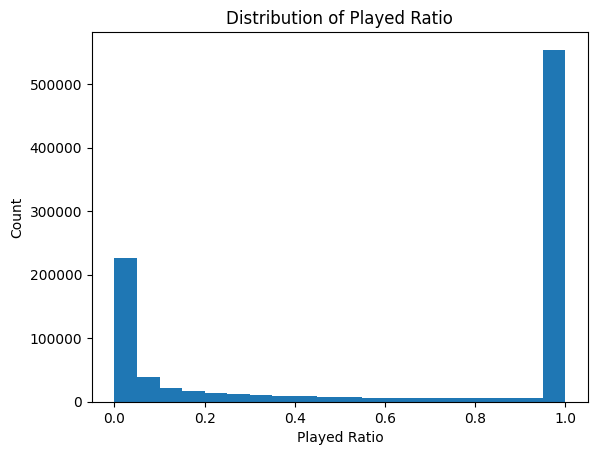

In [19]:
#Distribution Check

plt.hist(listens["played_ratio"], bins=20)
plt.title("Distribution of Played Ratio")
plt.xlabel("Played Ratio")
plt.ylabel("Count")
plt.show()

In [20]:
#Define Skip and Completion Carefully
listens["played_ratio"].quantile([0.1,0.25,0.5,0.75,0.9])

0.10    0.01
0.25    0.06
0.50    1.00
0.75    1.00
0.90    1.00
Name: played_ratio, dtype: float64

In [21]:
SKIP_THRESH = 0.25
COMP_THRESH = 0.90

In [22]:
#Compute Layer 1 Metrics
skip_rate = (listens["played_ratio"] < SKIP_THRESH).mean()
completion_rate = (listens["played_ratio"] > COMP_THRESH).mean()

like_rate = (
    df[df["event_type"] == "like"].shape[0] /
    listens.shape[0]
)

skip_rate, completion_rate, like_rate

(0.32468602801517027, 0.5751413208327588, 0.018617103370504432)

In [23]:
#Organic vs Algorithmic Comparison
algo = listens[listens["is_organic"] == 0]
organic = listens[listens["is_organic"] == 1]

algo_skip = (algo["played_ratio"] < SKIP_THRESH).mean()
org_skip = (organic["played_ratio"] < SKIP_THRESH).mean()

algo_comp = (algo["played_ratio"] > COMP_THRESH).mean()
org_comp = (organic["played_ratio"] > COMP_THRESH).mean()

algo_skip, org_skip, algo_comp, org_comp

(0.27375476886179767,
 0.3670177990387351,
 0.634776025007764,
 0.5255756379072234)

In [24]:
#Build Sessions
SESSION_GAP_BINS = 360

In [25]:
session_stats.describe()

,uid,n_listens,unique_tracks,algo_ratio,mean_played_ratio,skip_rate,unique_ratio
count,108927.000000,108927.000000,108927.000000,108927.000000,108927.000000,108927.000000,108927.000000
mean,11630.420373,8.922508,8.286192,0.439514,0.727582,0.240829,0.960676
std,6200.914285,15.992783,13.654630,0.479269,0.312064,0.321279,0.120810
min,100.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.005848
25%,6100.000000,2.000000,2.000000,0.000000,0.508000,0.000000,1.000000
50%,12500.000000,5.000000,4.000000,0.000000,0.851667,0.000000,1.000000
75%,17100.000000,10.000000,9.000000,1.000000,1.000000,0.444444,1.000000
max,21400.000000,1743.000000,596.000000,1.000000,1.590000,1.000000,1.000000


In [27]:
#Clip Played Ratio (>1 values)
# If you still have nulls, drop them first (recommended)
listens = listens.dropna(subset=["played_ratio"]).copy()

# Clip to [0, 1] for clean interpretation
listens["played_ratio"] = listens["played_ratio"].clip(lower=0.0, upper=1.0)

listens["played_ratio"].describe()

count    971902.000000
mean          0.641615
std           0.442487
min           0.000000
25%           0.060000
50%           1.000000
75%           1.000000
max           1.000000
Name: played_ratio, dtype: float64

In [28]:
#Clean Threshold Justification (quantile-based)
q = listens["played_ratio"].quantile([0.10, 0.25, 0.50, 0.75, 0.90, 0.95]).to_dict()
q

{0.1: 0.009999999776482582,
 0.25: 0.05999999865889549,
 0.5: 1.0,
 0.75: 1.0,
 0.9: 1.0,
 0.95: 1.0}

In [29]:
# Choose thresholds (quartile-based is easy to justify)
SKIP_THRESH = float(q[0.25])   # often around 0.06 in your sample
COMP_THRESH = float(q[0.90])   # often 1.0 in your sample; if so, use 0.95 or 0.90 fixed

# If COMP becomes 1.0 (common), force a more informative completion threshold:
if COMP_THRESH >= 0.999:
    COMP_THRESH = 0.90  # or 0.95, pick one and stick to it

print("SKIP_THRESH:", SKIP_THRESH, "COMP_THRESH:", COMP_THRESH)

SKIP_THRESH: 0.05999999865889549 COMP_THRESH: 0.9


In [30]:
method_sentence = (
    f"We define skips as playback completion below the empirical 25th percentile "
    f"(played_ratio < {SKIP_THRESH:.2f}), and completions as played_ratio > {COMP_THRESH:.2f}. "
    f"Thresholds are computed on the sampled listening events after clipping played_ratio to [0,1]."
)
method_sentence

'We define skips as playback completion below the empirical 25th percentile (played_ratio < 0.06), and completions as played_ratio > 0.90. Thresholds are computed on the sampled listening events after clipping played_ratio to [0,1].'

In [31]:
#Layer 1 summary + organic vs algo
def rate(x):
    return float(np.mean(x))

layer1_summary = {
    "n_listens": int(len(listens)),
    "skip_rate": rate(listens["played_ratio"] < SKIP_THRESH),
    "completion_rate": rate(listens["played_ratio"] > COMP_THRESH),
    "mean_played_ratio": float(listens["played_ratio"].mean()),
}

algo = listens[listens["is_organic"] == 0]
org  = listens[listens["is_organic"] == 1]

layer1_by_source = pd.DataFrame({
    "source": ["algorithmic(is_organic=0)", "organic(is_organic=1)"],
    "n": [len(algo), len(org)],
    "skip_rate": [rate(algo["played_ratio"] < SKIP_THRESH), rate(org["played_ratio"] < SKIP_THRESH)],
    "completion_rate": [rate(algo["played_ratio"] > COMP_THRESH), rate(org["played_ratio"] > COMP_THRESH)],
    "mean_played_ratio": [float(algo["played_ratio"].mean()), float(org["played_ratio"].mean())],
})

layer1_summary, layer1_by_source

({'n_listens': 971902,
  'skip_rate': 0.2430646299729808,
  'completion_rate': 0.5751413208327588,
  'mean_played_ratio': 0.6416148543357849},
                       source       n  skip_rate  completion_rate  \
 0  algorithmic(is_organic=0)  441143   0.195093         0.634776   
 1      organic(is_organic=1)  530759   0.282936         0.525576   
 
    mean_played_ratio  
 0           0.694649  
 1           0.597535  )

In [32]:
#Layer 2 summary (session_stats)
layer2_summary = session_stats[["n_listens","unique_ratio","algo_ratio","mean_played_ratio","skip_rate"]].describe()
layer2_summary

,n_listens,unique_ratio,algo_ratio,mean_played_ratio,skip_rate
count,108927.000000,108927.000000,108927.000000,108927.000000,108927.000000
mean,8.922508,0.960676,0.439514,0.727582,0.240829
std,15.992783,0.120810,0.479269,0.312064,0.321279
min,1.000000,0.005848,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.508000,0.000000
50%,5.000000,1.000000,0.000000,0.851667,0.000000
75%,10.000000,1.000000,1.000000,1.000000,0.444444
max,1743.000000,1.000000,1.000000,1.590000,1.000000


In [33]:
#Layer 3 summary (user_stats)
layer3_summary = user_stats[["n_sessions","active_span_days","mean_return_gap_hours"]].describe()
layer3_summary

,n_sessions,active_span_days,mean_return_gap_hours
count,194.000000,194.000000,194.000000
mean,561.479381,1138.888519,271.652816
std,615.167050,451.303108,719.125152
min,3.000000,9.661748,11.248911
25%,128.000000,853.429036,33.008051
50%,329.500000,1387.212818,67.993249
75%,840.000000,1495.063440,162.759958
max,3208.000000,1503.859086,6057.969444


In [34]:
# Safety: avoid weird infs
u = user_stats.copy()

# Retention proxy: frequent return => smaller mean_return_gap_hours
# We convert it into a "higher is better" signal by taking inverse.
eps = 1e-6
u["ret_signal_raw"] = 1.0 / (u["mean_return_gap_hours"].astype(float) + eps)

# Normalize to 0..1 so it plays nicely with other terms
u["user_retention_signal"] = (
    (u["ret_signal_raw"] - u["ret_signal_raw"].min()) /
    (u["ret_signal_raw"].max() - u["ret_signal_raw"].min() + eps)
)

u[["uid","mean_return_gap_hours","ret_signal_raw","user_retention_signal"]].head()

,uid,mean_return_gap_hours,ret_signal_raw,user_retention_signal
0,100,58.732792,0.017026,0.190021
1,200,1188.851496,0.000841,0.007619
2,300,394.583333,0.002534,0.026701
3,500,188.017795,0.005319,0.058079
4,600,98.734150,0.010128,0.112282


In [35]:
#Compute Item Popularity (from listens)
item_pop = listens["item_id"].value_counts().rename("popularity").reset_index()
item_pop = item_pop.rename(columns={"index":"item_id"})
item_pop.head(), item_pop["popularity"].describe()

(   item_id  popularity
 0  3542184         963
 1  5862961         901
 2  6901374         851
 3  9378983         833
 4  4341029         817,
 count    108380.000000
 mean          8.967540
 std          24.308298
 min           1.000000
 25%           1.000000
 50%           2.000000
 75%           7.000000
 max         963.000000
 Name: popularity, dtype: float64)

In [36]:
listens = listens.merge(
    u[["uid", "user_retention_signal"]],
    on="uid",
    how="left"
)

# Fill missing with median (in case some uids didn’t get user_stats)
listens["user_retention_signal"] = listens["user_retention_signal"].fillna(
    listens["user_retention_signal"].median()
)

In [37]:
listens.columns

Index(['uid', 'item_id', 'timestamp', 'is_organic', 'event_type',
       'played_ratio_pct', 'track_length_seconds', 'played_ratio', 'prev_ts',
       'gap', 'new_session', 'session_idx', 'session_id',
       'user_retention_signal'],
      dtype='object')

In [38]:
item_pop = listens["item_id"].value_counts().rename("popularity").reset_index()
item_pop = item_pop.rename(columns={"index": "item_id"})

listens = listens.merge(item_pop, on="item_id", how="left")
listens["inv_pop"] = 1.0 / np.log1p(listens["popularity"].astype(float))

listens[["item_id","popularity","inv_pop"]].head()

,item_id,popularity,inv_pop
0,8326270,138,0.202656
1,1441281,6,0.513898
2,286361,44,0.262697
3,732449,39,0.271085
4,3397170,8,0.455120


In [39]:
# Policy A: short-term only
listens["score_A"] = listens["played_ratio"]

# Policy B: short + novelty + retention
w1, w2, w3 = 0.4, 0.3, 0.3   # start here; you can tune later

listens["score_B"] = (
    w1 * listens["played_ratio"] +
    w2 * listens["inv_pop"] +
    w3 * listens["user_retention_signal"]
)

listens[["score_A","score_B","played_ratio","inv_pop","user_retention_signal"]].describe()

,score_A,score_B,played_ratio,inv_pop,user_retention_signal
count,971902.000000,971902.000000,971902.000000,971902.000000,971902.000000
mean,0.641615,0.485645,0.641615,0.379215,0.384116
std,0.442487,0.208725,0.442487,0.280337,0.234418
min,0.000000,0.044432,0.000000,0.145537,0.000000
25%,0.060000,0.288692,0.060000,0.225091,0.190021
50%,1.000000,0.537146,1.000000,0.281266,0.347090
75%,1.000000,0.638766,1.000000,0.402430,0.546797
max,1.000000,1.132805,1.000000,1.442695,0.999989


In [40]:
# --- Candidate expansion reranking (REPLACES the old groupby/apply cell) ---

TOPK = 20
N_USER_CANDS = 50
N_GLOBAL_CANDS = 50
SEED = 42

rng = np.random.default_rng(SEED)

# 1) Build item-level stats so we can score items not in the session
item_stats = (
    listens.groupby("item_id")
    .agg(item_mean_played_ratio=("played_ratio", "mean"),
         popularity=("played_ratio", "size"))
    .reset_index()
)
item_stats["inv_pop"] = 1.0 / np.log1p(item_stats["popularity"].astype(float))

# Define long-tail threshold (bottom 50% by popularity)
pop_median = item_stats["popularity"].median()

item_stats["is_long_tail"] = (
    item_stats["popularity"] <= pop_median
)

#Pools for sampling
global_items = item_stats["item_id"].values
user_item_pool = listens.groupby("uid")["item_id"].unique().to_dict()
session_item_pool = listens.groupby("session_id")["item_id"].unique().to_dict()
session_uid = listens.groupby("session_id")["uid"].first().to_dict()

# user retention lookup (you already merged it into listens)
user_ret_lookup = listens.groupby("uid")["user_retention_signal"].first().to_dict()

def safe_sample(arr, n, exclude_set):
    arr = np.array([x for x in arr if x not in exclude_set], dtype=np.int64)
    if len(arr) == 0:
        return np.array([], dtype=np.int64)
    if len(arr) <= n:
        return arr
    idx = rng.choice(len(arr), size=n, replace=False)
    return arr[idx]

rowsA, rowsB = [], []

for sid, sess_items_arr in session_item_pool.items():
    uid = session_uid[sid]
    sess_items = set(sess_items_arr)

    # Candidate set = session items + user-history samples + global samples
    user_pool = user_item_pool.get(uid, np.array([], dtype=np.int64))
    user_cands = safe_sample(user_pool, N_USER_CANDS, sess_items)
    global_cands = safe_sample(global_items, N_GLOBAL_CANDS, sess_items.union(set(user_cands)))

    cand_items = np.array(list(sess_items.union(set(user_cands)).union(set(global_cands))), dtype=np.int64)

    cand = item_stats[item_stats["item_id"].isin(cand_items)].copy()
    if cand.empty:
        continue

    ret = float(user_ret_lookup.get(uid, 0.5))
    cand["user_retention_signal"] = ret

    # Policy scores (note: using item_mean_played_ratio as expected engagement)
    cand["score_A"] = cand["item_mean_played_ratio"]

    w1, w2, w3 = 0.4, 0.3, 0.3
    cand["score_B"] = (
        w1 * cand["item_mean_played_ratio"] +
        w2 * cand["inv_pop"] +
        w3 * cand["user_retention_signal"]
    )

    topA = cand.nlargest(TOPK, "score_A")
    topB = cand.nlargest(TOPK, "score_B")

    def summarize(top, policy_name):
        return {
            "session_id": sid,
            "uid": uid,
            "policy": policy_name,
            "topk_pred_mean_played_ratio": float(top["item_mean_played_ratio"].mean()),
            "topk_unique_ratio": float(top["item_id"].nunique() / len(top)),
            "topk_mean_inv_pop": float(top["inv_pop"].mean()),
            "topk_user_ret_signal": float(ret),
            "cand_set_size": int(len(cand)),
            "topk_long_tail_share": float(top["is_long_tail"].mean())
        }

    rowsA.append(summarize(topA, "A_short_term"))
    rowsB.append(summarize(topB, "B_multi_layer_retention"))

policyA_session = pd.DataFrame(rowsA)
policyB_session = pd.DataFrame(rowsB)
policy_session = pd.concat([policyA_session, policyB_session], ignore_index=True)

policy_session.head(), policy_session.shape

(  session_id    uid        policy  topk_pred_mean_played_ratio  \
 0    10000_1  10000  A_short_term                     0.962555   
 1   10000_10  10000  A_short_term                     0.974964   
 2  10000_100  10000  A_short_term                     0.984179   
 3  10000_101  10000  A_short_term                     0.999000   
 4  10000_102  10000  A_short_term                     0.967756   
 
    topk_unique_ratio  topk_mean_inv_pop  topk_user_ret_signal  cand_set_size  \
 0                1.0           0.851385               0.08789            112   
 1                1.0           0.976332               0.08789            106   
 2                1.0           1.046818               0.08789            177   
 3                1.0           1.103347               0.08789            134   
 4                1.0           0.995284               0.08789            114   
 
    topk_long_tail_share  
 0                  0.45  
 1                  0.65  
 2                  0.65  


In [41]:
weight_configs = {
    "engagement_heavy": (0.6, 0.2, 0.2),
    "balanced": (0.5, 0.25, 0.25),
    "diversity_heavy": (0.4, 0.3, 0.3)
}

stress_results = []

for name, (w1, w2, w3) in weight_configs.items():

    rowsA, rowsB = [], []

    for sid, sess_items_arr in session_item_pool.items():
        uid = session_uid[sid]
        sess_items = set(sess_items_arr)

        user_pool = user_item_pool.get(uid, np.array([], dtype=np.int64))
        user_cands = safe_sample(user_pool, N_USER_CANDS, sess_items)
        global_cands = safe_sample(global_items, N_GLOBAL_CANDS, sess_items.union(set(user_cands)))

        cand_items = np.array(list(sess_items.union(set(user_cands)).union(set(global_cands))), dtype=np.int64)
        cand = item_stats[item_stats["item_id"].isin(cand_items)].copy()
        if cand.empty:
            continue

        ret = float(user_ret_lookup.get(uid, 0.5))
        cand["user_retention_signal"] = ret

        cand["score_A"] = cand["item_mean_played_ratio"]
        cand["score_B"] = (
            w1 * cand["item_mean_played_ratio"] +
            w2 * cand["inv_pop"] +
            w3 * cand["user_retention_signal"]
        )

        topA = cand.nlargest(TOPK, "score_A")
        topB = cand.nlargest(TOPK, "score_B")

        rowsA.append(topA["item_mean_played_ratio"].mean())
        rowsB.append(topB["item_mean_played_ratio"].mean())

    delta_engagement = np.mean(rowsB) - np.mean(rowsA)

    # compute novelty delta
    rowsA_nov, rowsB_nov = [], []
    for sid, sess_items_arr in session_item_pool.items():
        uid = session_uid[sid]
        sess_items = set(sess_items_arr)

        user_pool = user_item_pool.get(uid, np.array([], dtype=np.int64))
        user_cands = safe_sample(user_pool, N_USER_CANDS, sess_items)
        global_cands = safe_sample(global_items, N_GLOBAL_CANDS, sess_items.union(set(user_cands)))

        cand_items = np.array(list(sess_items.union(set(user_cands)).union(set(global_cands))), dtype=np.int64)
        cand = item_stats[item_stats["item_id"].isin(cand_items)].copy()
        if cand.empty:
            continue

        ret = float(user_ret_lookup.get(uid, 0.5))
        cand["user_retention_signal"] = ret

        cand["score_A"] = cand["item_mean_played_ratio"]
        cand["score_B"] = (
            w1 * cand["item_mean_played_ratio"] +
            w2 * cand["inv_pop"] +
            w3 * cand["user_retention_signal"]
        )

        topA = cand.nlargest(TOPK, "score_A")
        topB = cand.nlargest(TOPK, "score_B")

        rowsA_nov.append(topA["inv_pop"].mean())
        rowsB_nov.append(topB["inv_pop"].mean())

    delta_novelty = np.mean(rowsB_nov) - np.mean(rowsA_nov)

    stress_results.append({
        "config": name,
        "delta_pred_engagement": delta_engagement,
        "delta_inv_pop": delta_novelty
    })

stress_df = pd.DataFrame(stress_results)
stress_df

,config,delta_pred_engagement,delta_inv_pop
0,engagement_heavy,-0.007101,0.119608
1,balanced,-0.016748,0.142601
2,diversity_heavy,-0.043667,0.185457


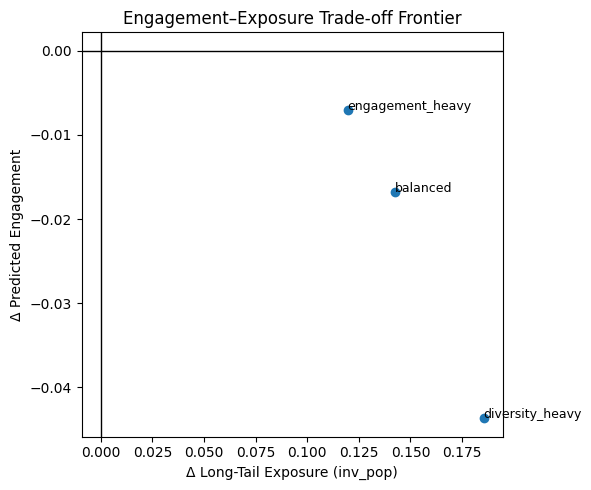

In [42]:
plt.figure(figsize=(6,5))

plt.scatter(
    stress_df["delta_inv_pop"],
    stress_df["delta_pred_engagement"]
)

for i, row in stress_df.iterrows():
    plt.text(
        row["delta_inv_pop"],
        row["delta_pred_engagement"],
        row["config"],
        fontsize=9
    )

plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

plt.xlabel("Δ Long-Tail Exposure (inv_pop)")
plt.ylabel("Δ Predicted Engagement")
plt.title("Engagement–Exposure Trade-off Frontier")
plt.tight_layout()
plt.show()

In [43]:
compare = policy_session.groupby("policy")[[
    "topk_pred_mean_played_ratio",
    "topk_mean_inv_pop",
    "topk_long_tail_share"
]].mean().round(4)

compare

,topk_pred_mean_played_ratio,topk_mean_inv_pop,topk_long_tail_share
policy,,,
A_short_term,0.9888,1.0719,0.6835
B_multi_layer_retention,0.9451,1.2578,0.8759


In [44]:
A = policyA_session.set_index("session_id")
B = policyB_session.set_index("session_id")
common = A.index.intersection(B.index)
A = A.loc[common]; B = B.loc[common]

cols = [
    "topk_pred_mean_played_ratio",
    "topk_mean_inv_pop",
    "topk_long_tail_share"
]
delta = B[cols] - A[cols]
delta_means = delta.mean().sort_values()
delta_means

topk_pred_mean_played_ratio   -0.043753
topk_mean_inv_pop              0.185890
topk_long_tail_share           0.192443
dtype: float64

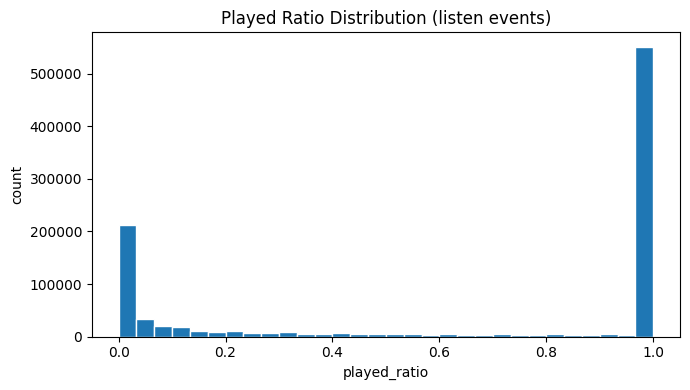

In [45]:
plt.figure(figsize=(7,4))
plt.hist(listens["played_ratio"], bins=30, edgecolor="white")
plt.title("Played Ratio Distribution (listen events)")
plt.xlabel("played_ratio")
plt.ylabel("count")
plt.tight_layout()
plt.show()

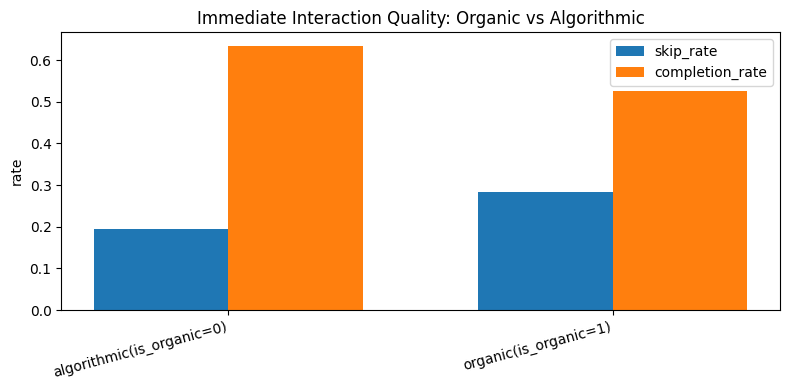

In [46]:
#Organic vs Algorithmic Bar Chart (skip + completion)

algo = listens[listens["is_organic"] == 0]
org  = listens[listens["is_organic"] == 1]

bars = pd.DataFrame({
    "source": ["algorithmic(is_organic=0)", "organic(is_organic=1)"],
    "skip_rate": [
        float((algo["played_ratio"] < SKIP_THRESH).mean()),
        float((org["played_ratio"] < SKIP_THRESH).mean())
    ],
    "completion_rate": [
        float((algo["played_ratio"] > COMP_THRESH).mean()),
        float((org["played_ratio"] > COMP_THRESH).mean())
    ]
})

x = np.arange(len(bars))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, bars["skip_rate"], width, label="skip_rate")
plt.bar(x + width/2, bars["completion_rate"], width, label="completion_rate")
plt.xticks(x, bars["source"], rotation=15, ha="right")
plt.title("Immediate Interaction Quality: Organic vs Algorithmic")
plt.ylabel("rate")
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Align on the same sessions
A = policyA_session.set_index("session_id")
B = policyB_session.set_index("session_id")

common = A.index.intersection(B.index)
A = A.loc[common]
B = B.loc[common]

# Keep ONLY numeric topk_ columns (this also drops 'policy')
cols = [c for c in A.columns if c.startswith("topk_")]
cols = [c for c in cols if pd.api.types.is_numeric_dtype(A[c]) and pd.api.types.is_numeric_dtype(B[c])]

delta = B[cols] - A[cols]
delta_means = delta.mean().sort_values()

delta_means

topk_pred_mean_played_ratio   -0.043753
topk_unique_ratio              0.000000
topk_user_ret_signal           0.000000
topk_mean_inv_pop              0.185890
topk_long_tail_share           0.192443
dtype: float64

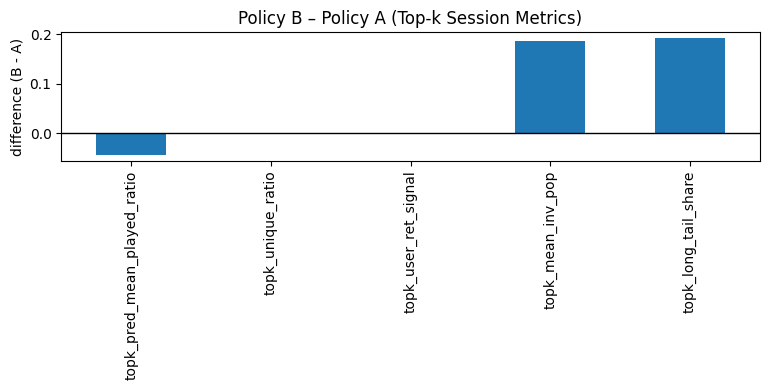

In [48]:
#Policy A vs Policy B comparison plot
plt.figure(figsize=(8,4))
delta_means.plot(kind="bar")
plt.axhline(0, color="black", linewidth=1)
plt.title("Policy B – Policy A (Top-k Session Metrics)")
plt.ylabel("difference (B - A)")
plt.tight_layout()
plt.show()

In [49]:
listens[["played_ratio","inv_pop","user_retention_signal","score_B"]].corr(numeric_only=True)

,played_ratio,inv_pop,user_retention_signal,score_B
played_ratio,1.000000,-0.036974,0.087008,0.862397
inv_pop,-0.036974,1.000000,-0.071420,0.347511
user_retention_signal,0.087008,-0.071420,1.000000,0.381932
score_B,0.862397,0.347511,0.381932,1.000000
